# Regression
### Building a model from housing prices
#### The Problem
suppervised learning regression task
#### Performance Measure
RMSE

---

#### Download data

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

#### Read in data

In [2]:
import pandas as pd

def load_housing_data(housing_path=os.path.join("..", HOUSING_PATH)):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
# each row represents a district
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# one of the attributes is categorical
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# describe data at the district level
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


There are some transformation that we'll need to apply to some of these features

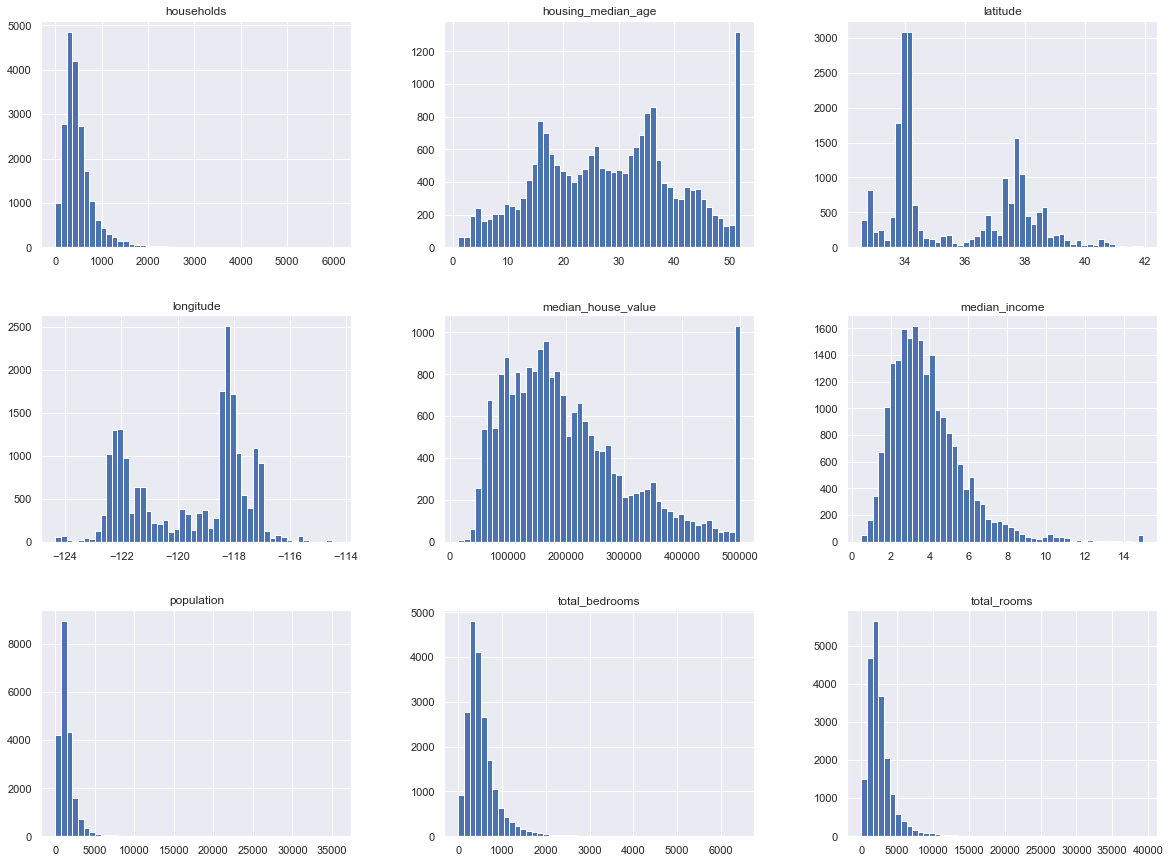

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

One way of splitting up the data into training and testing sets is by randomly choosing X% to go into training and the rest into testing. This is fine most of the time but can result in sampling bias if the data is too small

In [9]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

To avoid any possible sampling bias, let's use stratified sampling on a categorical version of our median income response variable

In [10]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

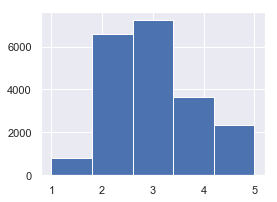

In [11]:
housing["income_cat"].hist(bins=5, figsize=(4, 3))

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's make it worked

In [13]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [14]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Now we can remove income category work with the original data

In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let's explore the data some more<br>

By plotting lat x long we can sort of see the shape of California. We can see high density areas by using the alpha plotting parameter.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


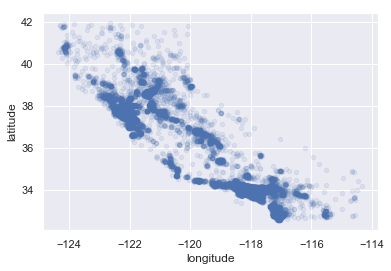

In [16]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

Now let's looking at the housing prices by lat x long

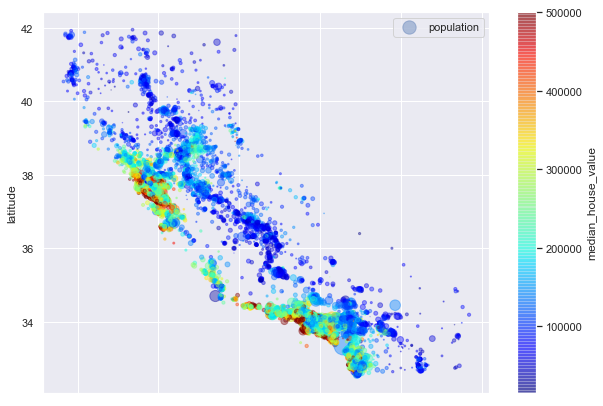

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend();

#### Looking for correlations
Can we find any linear coorelations in the data?

In [18]:
corr_matrix = housing.corr()

In [19]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [20]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

What are other ways of looking for correlations betwee variables?

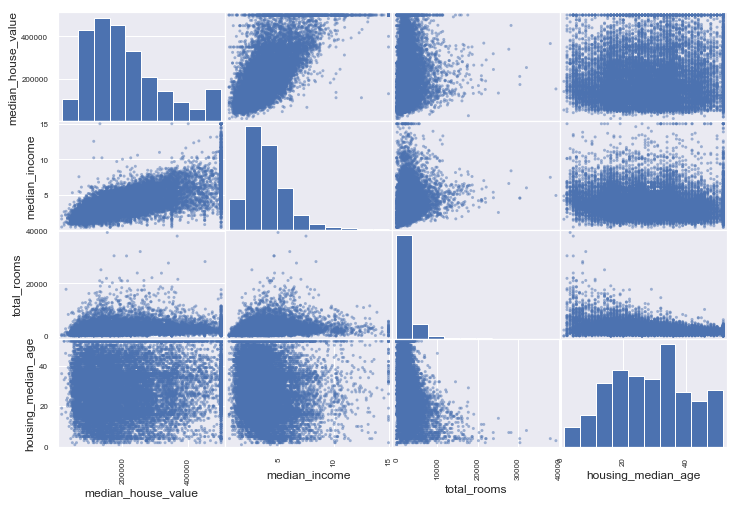

In [21]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8));

Median income looks to be stronly correlated with median house value

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


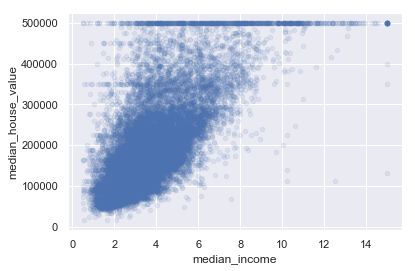

In [22]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);

Are there any attribute combinations that we would be interested in exploring?

In [23]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [24]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

#### Algos
Let's do some data prep to start appplying algos

In [25]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing_test = strat_test_set.drop("median_house_value", axis=1)
housing_test_labels = strat_test_set["median_house_value"].copy()

Start by filling in empty values

In [26]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

print("calculated medians: ")
print(imputer.statistics_)

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

calculated medians: 
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


Now let's convert our categorical variable to be numeric

In [27]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder() # this is a estimator/transformer
housing_cat = housing[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(ordinal_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


This works fine, but we want to avoid a learning algorithm thinking that "<1H OCEAN" is similar to "INLAND" because of their numerical categories (0 & 1) are close to each other. 

In [28]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) # returns a sparse matrix

In certain cases we might want to create our own transformers

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

We'll want to scale every feature so that each features range isn't so drastically different. We can do this with <em>min-max scalding</em> { ( x - min) / (max - min) } or with <em>standardization</em> { (x - x-bar) / sigma }

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [31]:
housing_num_tr[:1]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753]])

How can we handle both the numerical and categorical attributes together?

In [32]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)   # numerical attributes
cat_attribs = ["ocean_proximity"] # categorical attribtues

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs)
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_test_prepared = full_pipeline.fit_transform(strat_test_set)

In [33]:
housing_prepared[:1]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

#### Model Training

In [34]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels);

That was too easy, let's do some minor checks

In [35]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
prediction = lin_reg.predict(some_data_prepared)
print("predictions: ", prediction)
print("actual: ", list(some_labels))

predictions:  [208393.14747164 320764.50952653 208814.28566975  60711.58774608
 187291.36468145]
actual:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Overall our score is pretty bad at the moment

In [36]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [37]:
# can also be calculated this way:
np.sqrt(
    np.sum(
        np.abs((housing_predictions - housing_labels) ** 2
    )
)/ len(housing_predictions))

68628.19819848922

How would we improve it?<br>

Let's try a different model

In [40]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg_train_predictions = tree_reg.fit(housing_prepared, housing_labels).predict(housing_prepared)
tree_reg_train_mse = mean_squared_error(housing_labels, tree_reg_train_predictions)
tree_reg_train_rmse = np.sqrt(tree_reg_train_mse)
tree_reg_train_rmse

0.0

Ehhh, this is likely overfitting so let's try to change up a few things

In [41]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

In [42]:
print("scores: ", list(tree_rmse_scores))
print("mean: ", np.mean(tree_rmse_scores))
print("std: ", np.std(tree_rmse_scores))

scores:  [69468.62888042042, 70831.39496054854, 72648.36266347735, 71439.66903728964, 73941.65014448651]
mean:  71665.94113724449
std:  1531.0030097353344


In [44]:
# tree_reg_mse = mean_squared_error(housing_labels, tree_reg_predictions)
# tree_reg_rmse = np.sqrt(tree_reg_mse)
# tree_reg_rmse

Let's see how random forest does

In [45]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("scores: ", list(forest_rmse_scores))
print("mean: ", np.mean(forest_rmse_scores))
print("std: ", np.std(forest_rmse_scores))

/Users/Ipanema/src/gstvolvr/notebooks/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


scores:  [52531.83233136641, 48916.667662590036, 52986.65984313546, 54121.38253603216, 51518.67465775633, 55743.12391448699, 51158.453787651524, 50087.413143377315, 56860.68787492117, 52476.63803547669]
mean:  52640.1533786794
std:  2315.7696696713897


Would grid search help?

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

forest_reg = RandomForestRegressor()
# tree_reg.fit(housing_prepared, housing_labels)
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [47]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [48]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
     print(np.sqrt(-mean_score), params)

64524.38138967437 {'max_features': 2, 'n_estimators': 3}
55520.91284900073 {'max_features': 2, 'n_estimators': 10}
52808.05293842142 {'max_features': 2, 'n_estimators': 30}
61059.89650067597 {'max_features': 4, 'n_estimators': 3}
52480.08005031927 {'max_features': 4, 'n_estimators': 10}
50537.75495596251 {'max_features': 4, 'n_estimators': 30}
58404.95231849196 {'max_features': 6, 'n_estimators': 3}
51746.05108153461 {'max_features': 6, 'n_estimators': 10}
49994.84881180545 {'max_features': 6, 'n_estimators': 30}
58446.82449451402 {'max_features': 8, 'n_estimators': 3}
52033.3354896332 {'max_features': 8, 'n_estimators': 10}
50038.098101795396 {'max_features': 8, 'n_estimators': 30}
63358.37012651542 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53796.488963788375 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60282.58824045306 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52502.28023719766 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

How useful is each feature?

In [49]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.30602948906451194, 'median_income'),
 (0.17059829986176075, 'INLAND'),
 (0.10718806994243592, 'pop_per_hhold'),
 (0.07845268607436306, 'bedrooms_per_room'),
 (0.07400553548273213, 'rooms_per_hhold'),
 (0.07291960970084163, 'longitude'),
 (0.06529501028578168, 'latitude'),
 (0.043593739072461536, 'housing_median_age'),
 (0.01809527024969185, 'population'),
 (0.017891218254216076, 'total_rooms'),
 (0.016403287626066524, 'total_bedrooms'),
 (0.015644932503255656, 'households'),
 (0.007565486677191408, '<1H OCEAN'),
 (0.0034431964157615102, 'NEAR OCEAN'),
 (0.002800963461938284, 'NEAR BAY'),
 (7.320532699003053e-05, 'ISLAND')]

Let's try evaluating it on the test set

In [51]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 
final_rmse

65512.33974746485

In [52]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                          loc=squared_errors.mean(),
                          scale=stats.sem(squared_errors)))

array([63619.83535859, 67351.68793223])